In [1]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import device, get_all_preds, get_num_correct

In [2]:
# declare tranformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

In [3]:
# get train and test directories
dirs = {
    'train': 'COVID-19 Radiography Database/train',
    'test': 'COVID-19 Radiography Database/test'
}

# prepare data-loaders
train_set = torchvision.datasets.ImageFolder(root=dirs['train'], transform=transform)
test_set = torchvision.datasets.ImageFolder(root=dirs['test'], transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=120)

In [4]:
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(
    torch.load('model/lr3e-5-resnet18-covid.pth',
    map_location=device)
)  # load the pretrained resnet18 model

resnet18.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
with torch.no_grad():
    train_preds = get_all_preds(resnet18, train_loader)
    test_preds = get_all_preds(resnet18, test_loader)
    print(train_preds.shape)  # shape of the predicted train scores
    print(test_preds.shape)  # shape of the predicted test scores

torch.Size([2785, 3])
torch.Size([120, 3])


In [6]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct:  2766	Train Accuracy: 99.32%
Test Correct:    116	Test Accuracy:  96.67%


In [7]:
# stack the correct label and the predicted label side by side
train_stacked = torch.stack(
    (torch.as_tensor(train_set.targets), train_preds.argmax(dim=1)),
    dim=1
)  # shape [2785, 2]
test_stacked = torch.stack(
    (torch.as_tensor(test_set.targets), test_preds.argmax(dim=1)),
    dim=1
)  # shape [120, 2]

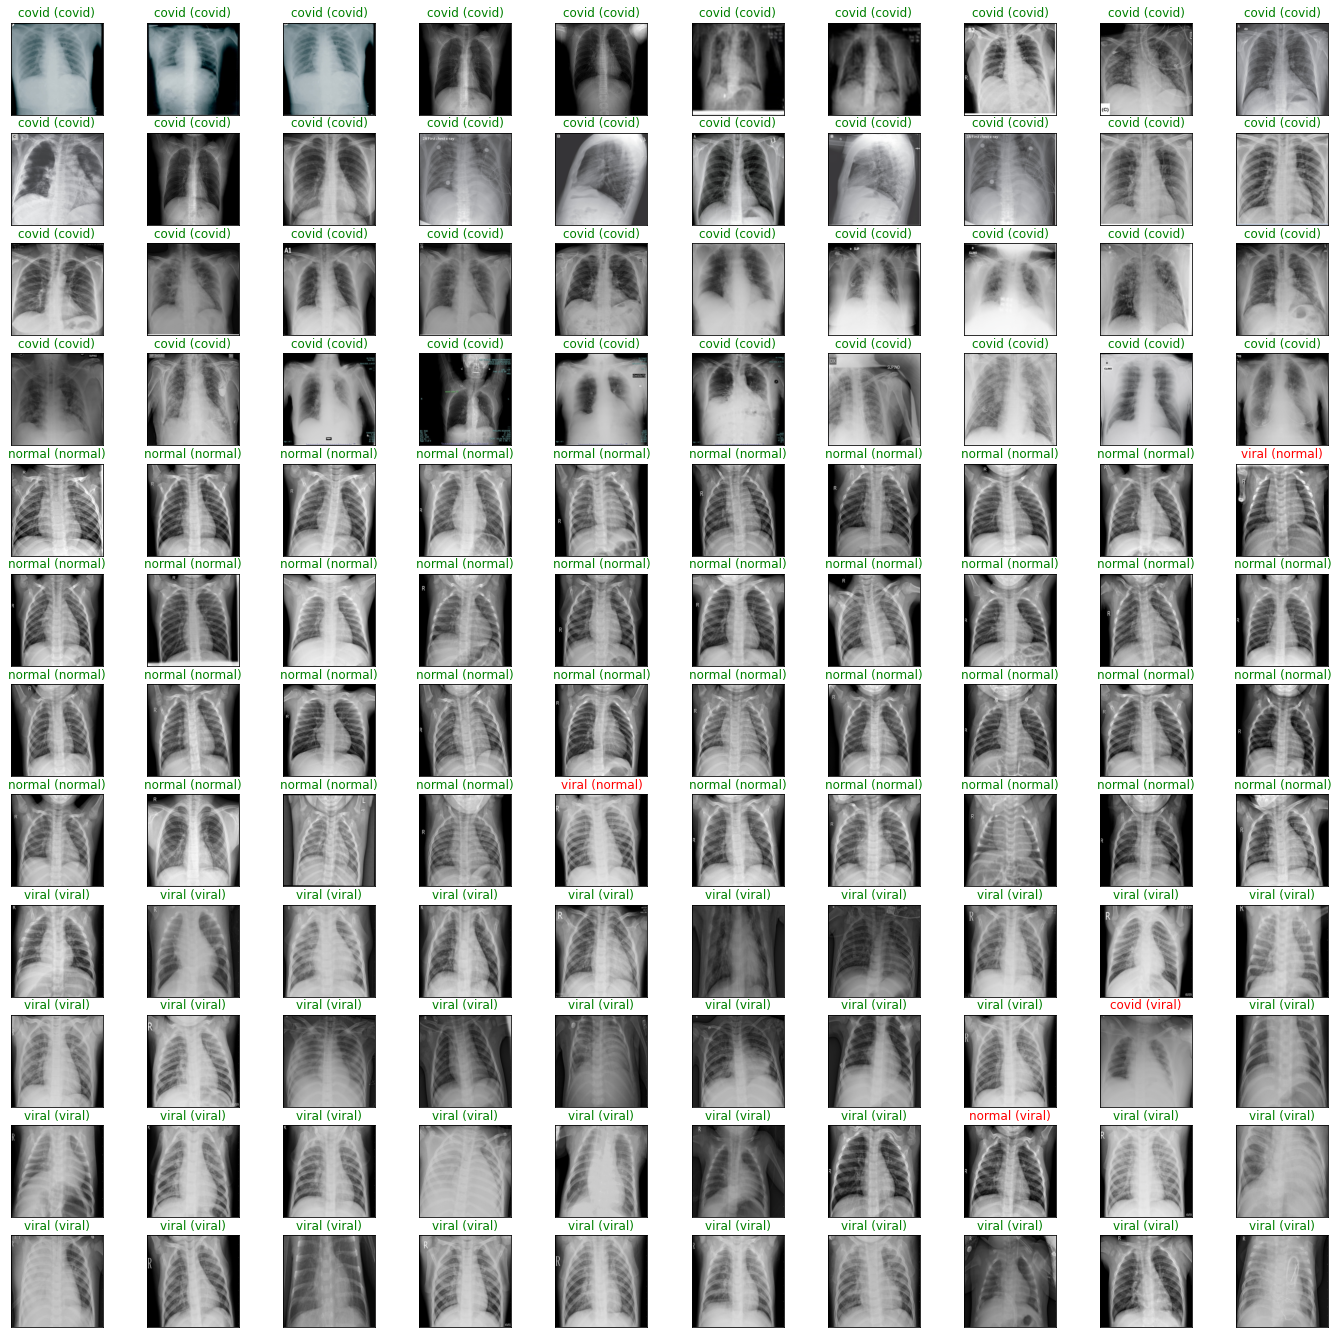

In [11]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
# plot format: "predicted-label (true-label)"
fig = plt.figure(figsize=(24, 24))
for i in np.arange(120):
    ax = fig.add_subplot(12, 10, i+1, xticks=[], yticks=[])
    image = np.squeeze(np.transpose(images[i], (1, 2, 0)))  # B*C*H*W --> H*W*C
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))  # un-normalize the image
    image = image.clip(0, 1)  # clip the values between 0 and 1
    ax.imshow(image)
    ax.set_title(f'{test_set.classes[test_stacked[i, 1].item()]} ({test_set.classes[labels[i].item()]})',
                color=('green' if test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig('images/test_results.png', bbox_inches='tight')
plt.close()

In [12]:
# calculate the confusion matrix for the train_set using train_stacked we calculated above
train_confmat = torch.zeros(3, 3, dtype=torch.int)
for row in train_stacked:
    cl, pl = row.tolist()
    train_confmat[cl, pl] += 1

train_confmat

tensor([[ 179,    0,    0],
        [   1, 1287,   13],
        [   0,    5, 1300]], dtype=torch.int32)

In [13]:
# calculate the confusion matrix for the test_set using test_stacked we calculated above
test_confmat = torch.zeros(3, 3, dtype=torch.int8)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[40,  0,  0],
        [ 0, 38,  2],
        [ 1,  1, 38]], dtype=torch.int8)

In [14]:
# print per-class train accuracy
for i in range(3):
    print('Train accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        train_set.classes[i],
        100 * (train_confmat[i,i]/torch.as_tensor(train_set.targets).bincount()[i].item()),
        train_confmat[i,i],
        torch.as_tensor(train_set.targets).bincount()[i].item()
    ))

Train accuracy of covid       :	100.00% (179/179)
Train accuracy of normal      :	98.92% (1287/1301)
Train accuracy of viral       :	99.62% (1300/1305)


In [15]:
# print per-class test accuracy
for i in range(3):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (test_confmat[i,i]/torch.as_tensor(test_set.targets).bincount()[i].item()),
        test_confmat[i,i],
        torch.as_tensor(test_set.targets).bincount()[i].item()
    ))

Test accuracy of covid       :	100.00% (40/40)
Test accuracy of normal      :	95.00% (38/40)
Test accuracy of viral       :	95.00% (38/40)
